In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def normalize_z(df):
    '''Input df, output dfout
    Z Normalizes a dataframe'''
    
    dfout = df.copy()
    dfout = (dfout - df.mean(axis=0)) / df.std(axis=0)
    
    return dfout

# def min_max

def get_features_targets(df, feature_names, target_names):
    '''input: df, ['feature_names'], ['target_names']
    output: df_feature, df_target'''
    
    df_feature = df[feature_names]
    df_target = df[target_names]
    
#     print(type(df_feature))
    
    return df_feature, df_target


def prepare_feature(df_feature):
    '''prepares the feature
    input: df_feature \n output: prepared_df_feature'''
    
    # get the number of columns, number of features
    cols = len(df_feature.columns)
    
    # shape the feature columns
    # why -1 for row? Transpose
    feature = df_feature.to_numpy().reshape(-1, cols)
    rows = feature.shape[0] # get number of rows
    
    # create our ones
    ones = np.ones((rows, 1))
    
    X = np.concatenate((ones, feature), axis=1)
    
    return X


def prepare_target(df_target):
    '''prepares the target
    input: df_target
    output: prepared_target'''
    
    cols = len(df_target.columns)
    target = df_target.to_numpy().reshape(-1, cols)
    return target


def predict(df_feature, beta):
    
    # normalize and prepare the feature
    X = prepare_feature(normalize_z(df_feature))
    
    return calc_linear(X, beta)


def calc_linear(X, beta):
    '''input: X, beta output: y= X cross B'''
    
    return np.matmul(X, beta)


def gradient_descent(X, y, beta, alpha, num_iters):
    '''input: X, y, beta, alpha, num_iters
    output: beta, J_storage(list of all costs computed with using beta)'''
    
    # get number of rows
    m = X.shape[0]
    
    # initialize J storage which stores all the successive iterations of cost function
    J_storage = np.zeros((num_iters, 1))
    
    # compute cost and store in J_storage each succesive iteration of cost function
    for n in range(num_iters):
        deriv = np.matmul(X.T, (calc_linear(X, beta) - y))
        beta = beta - alpha * (1/m) * deriv
        J_storage[n] = compute_cost(X, y, beta)
        
    return beta, J_storage


def compute_cost(X, y, beta):
    
    n = X.shape[0]
    
    # error = yhat - y
    error = calc_linear(X, beta) - y
    error_sq = np.matmul(error.T, error) # transpose the error matrix
    # multiply by itself
    
    J = (1/(2*n)) * error_sq
    
    return J


def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    '''splits data into training and testing
    input: df_feature, df_target, random_state=100, test_size=0.3
    output: df_feature_train, df_feature_test, df_target_train, df_target_test'''
    np.random.seed(random_state)
    n = len(df_feature)
    
    test_num = int(n * (test_size))
    
    test_idx = np.random.choice(n, test_num, replace=False) # all the indexes of the test indexes
    train_idx = [i for i in range(n) if i not in test_idx]
    
    df_feature_test = df_feature.iloc[test_idx]
    df_feature_train = df_feature.iloc[train_idx]
    
    df_target_test = df_target.iloc[test_idx]
    df_target_train = df_target.iloc[train_idx]
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
    
def r2_score(y, ypred):
    '''finds the R^2 score
    input y(np_array) actual values, ypred(np_array) predicted values
    output R^2'''
    
    n = len(y)
    
    y_bar = np.mean(y)
    
    # SS_res = summation (true_y - y_pred)**2
    SS_res = 0
    for true_y, pred_y in zip(y, ypred):
        SS_res += (true_y - pred_y)**2
    
    # SS_tot = summation (true_y - y_bar)**2
    SS_tot = 0
    for true_y in y:
        SS_tot += (true_y - y_bar)**2    
    
    r_2 = 1 - (SS_res / SS_tot)
    
    return r_2
    pass


def mean_squared_error(target, pred):
    '''finds the mean squared error
    input target(np_array), pred(np_array)
    output mean_squared_error'''
    
    n = len(target)
    
    # summation of (actual_y - y_cap)**2
    MSE = 0
    for actual_y, pred_y in zip(target, pred):
        MSE += (actual_y - pred_y)**2
    MSE /= n
    
    return MSE
    pass

In [3]:
#read necessary files
df_Phase1 = pd.read_csv('Phase1.csv')
df_Education = pd.read_csv('Education.csv')
df_Temperature = pd.read_csv('Temperature.csv')
df_Emission = pd.read_csv('Emission.csv')
df_Area = pd.read_csv('Area.csv')
df_Population = pd.read_csv('Population.csv')

In [4]:
# The datas used in phase 1
countries_phase1 = df_Phase1['Area']
population = df_Phase1.loc[:,['Population(1000persons)']]

In [5]:
# To ectract the countries from files
def extract_name(df):
    name = []
    for i in df:
        name.append(i)
    return name

In [6]:
countries_ed = extract_name(df_Education['Area'].apply(lambda x: x[1::]))
countries_temp = extract_name(df_Temperature['Area'])
countries_em = extract_name(df_Emission['Area'])
countries_area = extract_name(df_Area['Country Name'])
print(len(countries_ed), len(countries_temp), len(countries_em), len(countries_area))

189 239 220 266


In [7]:
# To find the countries exist in all the files
countries = []
i = 0
for country in countries_phase1:
    i += 1
    if country in countries_ed and country in countries_temp and country in countries_em and country in countries_area:
        countries.append(country)
print(len(countries),i)

103 118


In [8]:
# To slice the values for the countries
# df_filter is the column of country in file
def slicing(df, df_filter, column, ls):
    index = []
    for i in range(len(df_filter)):
        if df_filter.loc[i, :].item() in ls:
            index.append(i)
        # drop the prefix '?''
        elif df_filter.loc[i, :].item()[0] == '?':
            if df_filter.loc[i, :].item()[1::] in ls:
                index.append(i)
    df_out = df.loc[index, column]
    return [i for i in df_out]

In [9]:
ls_edu = slicing(df_Education, df_Education.loc[:, ['Area']], 'Education level', countries)
ls_temp = slicing(df_Temperature, df_Temperature.loc[:, ['Area']], 'Value', countries)
ls_em = slicing(df_Emission, df_Emission.loc[:, ['Area']], 'Value', countries)
ls_la = slicing(df_Area, df_Area.loc[:, ['Country Name']], '2019', countries)
ls_pop = slicing(df_Population, df_Population.loc[:, ['Area']], 'Value', countries)
ls_production = slicing(df_Phase1, df_Phase1.loc[:, ['Area']], 'Production per person(kg)', countries)

In [10]:
# To generate a new column by divides one with the other
def divide(ls1, ls2):
    output = []
    if len(ls1) == len(ls2):
        for i in range(len(ls1)):
            output.append(ls1[i]/ls2[i])
        return output
    else:
        print('!=')

In [12]:
# Perpare lists for dataframe
import math
ls_pop_density = divide(ls_pop, ls_la)
ls_emission_per_cap = divide(ls_em, ls_pop)
ls_emission_per_cap_ = [i*1000 for i in ls_emission_per_cap]

# variables added after modification
ls_pop_density_sqrt = [math.sqrt(i) for i in ls_pop_density]
ls_education_sqr = [i ** 2 for i in ls_edu] 
ls_temp_sqr = [i ** 2 for i in ls_temp]
ls_emission_per_cap_inv = [i ** -1 for i in ls_emission_per_cap_]
ls_pop_density_inv = [i ** -1 for i in ls_pop_density]

In [13]:
# Create the database of our model
# Create a new dataframe
df_data = pd.DataFrame()
# Add columns
df_data['Area'] = countries
df_data['Production per cap'] = ls_production
df_data['Education'] = ls_edu
df_data['Temperature'] = ls_temp
df_data['Emission'] = ls_em
df_data['Emission per cap'] = ls_emission_per_cap_
df_data['Population'] = ls_pop
df_data['Land Area'] = ls_la
df_data['Population Density'] = ls_pop_density
df_data['Population Density SQRT'] = ls_pop_density_sqrt
df_data['Education^'] = ls_education_sqr
df_data['Temperature^'] = ls_temp_sqr
df_data['Emission per cap^'] = ls_emission_per_cap_inv
df_data['Population Density^'] = ls_pop_density_inv

# Drop nan values
df_data.dropna(inplace=True)
display(df_data)

,Area,Production per cap,Education,Temperature,Emission,Emission per cap,Population,Land Area,Population Density,Population Density SQRT,Education^,Temperature^,Emission per cap^,Population Density^
0,Afghanistan,147.829889,0.414,0.960,117.0798,3.099850,37769.499,652230.0,0.057908,0.240641,0.171396,0.921600,0.322596,17.268696
1,Albania,231.764828,0.746,1.823,322.5184,112.223914,2873.883,27400.0,0.104886,0.323861,0.556516,3.323329,0.008911,9.534139
2,Algeria,131.917508,0.672,1.094,352.1759,8.246642,42705.368,2381741.0,0.017930,0.133904,0.451584,1.196836,0.121261,55.771466
3,Angola,90.266119,0.500,1.975,188.5210,5.826896,32353.588,1246700.0,0.025951,0.161094,0.250000,3.900625,0.171618,38.533593
4,Armenia,69.156513,0.740,1.853,403.7964,143.159652,2820.602,28470.0,0.099073,0.314758,0.547600,3.433609,0.006985,10.093590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Ukraine,1683.790153,0.799,2.355,4029.0359,91.131785,44211.094,579400.0,0.076305,0.276234,0.638401,5.546025,0.010973,13.105308
99,Uruguay,1039.803302,0.765,0.862,506.6267,147.773122,3428.409,175020.0,0.019589,0.139960,0.585225,0.743044,0.006767,51.049918
100,Uzbekistan,212.138054,0.729,1.930,174.3026,5.285589,32976.948,440555.0,0.074853,0.273593,0.531441,3.724900,0.189194,13.359484
101,Zambia,120.950432,0.557,1.295,103.3521,5.622928,18380.477,743390.0,0.024725,0.157243,0.310249,1.677025,0.177843,40.444543


In [14]:
## split into features and targets

feature_names = ['Education', 'Temperature',  'Emission per cap',  'Land Area', 'Population Density']
target_name = ['Production per cap']

df_features, df_target = get_features_targets(df_data, feature_names, target_name)

df_features.shape

(102, 5)

In [15]:
## split into training and testing sets
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, test_size=0.2)
df_features_train_z = normalize_z(df_features_train)

print(df_features_train.shape)
print(df_target_train.shape)

(82, 5)
(82, 1)


In [16]:
## train the model

X_train = prepare_feature(df_features_train_z)
print(X_train.shape)
target_train = prepare_target(df_target_train)

(82, 6)


[[409.19549097]
 [142.25116667]
 [154.18505896]
 [-55.48262602]
 [ 64.15973105]
 [-73.14450926]]


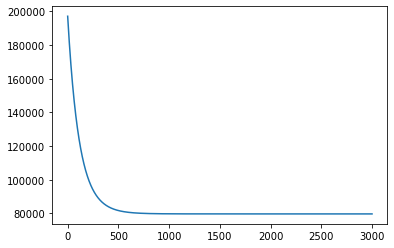

In [17]:
iterations = 3000
alpha = 0.004
beta = np.zeros((6,1))

beta, J_storage = gradient_descent(X_train, target_train, beta, alpha, iterations)

print(beta)

plt.plot(J_storage)


In [18]:
pred = predict(df_features_test, beta)

print(pred)

[[186.17925627]
 [764.46918448]
 [218.78919527]
 [648.36153697]
 [315.24164908]
 [655.18402141]
 [196.46932376]
 [507.89194663]
 [378.06137491]
 [614.19632424]
 [481.08332161]
 [128.92684707]
 [655.24830461]
 [107.83481631]
 [ 35.27905674]
 [751.35184419]
 [197.38698694]
 [693.71312338]
 [418.14398967]
 [230.09771584]]


In [19]:
## test the model

target_test = prepare_target(df_target_test)

mse = mean_squared_error(target_test, pred)

R2 = r2_score(target_test, pred)

print('beta: ', beta)
print('mse: ', mse)
print('r2_score: ', R2)

beta:  [[409.19549097]
 [142.25116667]
 [154.18505896]
 [-55.48262602]
 [ 64.15973105]
 [-73.14450926]]
mse:  [131603.38956777]
r2_score:  [0.37319913]


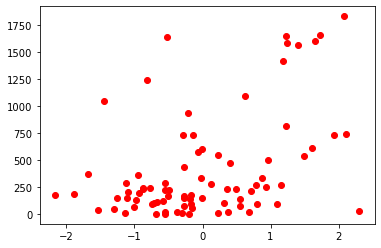

In [20]:
plt.scatter(df_features_train_z['Temperature'], df_target_train['Production per cap'], color='red')

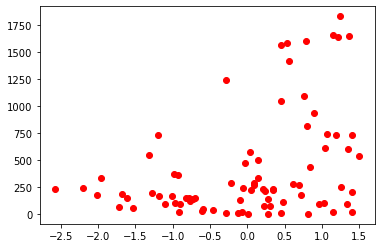

In [21]:
plt.scatter(df_features_train_z['Education'], df_target_train['Production per cap'], color='red')

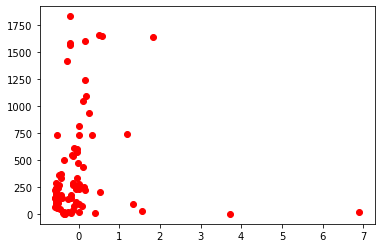

In [22]:
plt.scatter(df_features_train_z['Emission per cap'], df_target_train['Production per cap'], color='red')

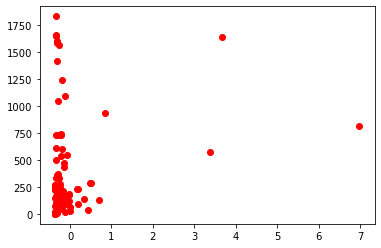

In [23]:
plt.scatter(df_features_train_z['Land Area'], df_target_train['Production per cap'], color='red')

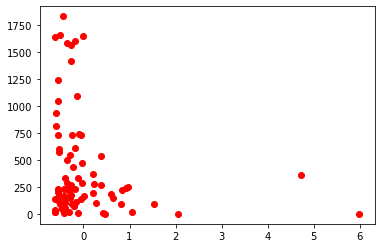

In [24]:
plt.scatter(df_features_train_z['Population Density'], df_target_train['Production per cap'], color='red')

In [25]:
## split into features and targets

feature_names = ['Education^', 'Temperature^',  'Emission per cap^',  'Land Area', 'Population Density SQRT']
target_name = ['Production per cap']

df_features, df_target = get_features_targets(df_data, feature_names, target_name)

df_features.shape

(102, 5)

In [26]:
## split into training and testing sets
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, test_size=0.2)
df_features_train_z = normalize_z(df_features_train)

print(df_features_train.shape)
print(df_target_train.shape)

(82, 5)
(82, 1)


In [27]:
## train the model

X_train = prepare_feature(df_features_train_z)
target_train = prepare_target(df_target_train)

[[409.19549097]
 [120.75218309]
 [171.56854976]
 [ -1.65482197]
 [ 56.27638252]
 [-71.33561781]]


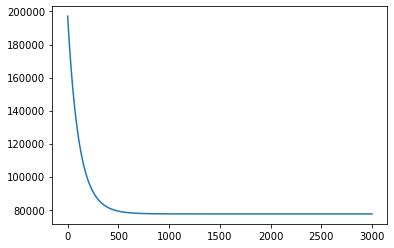

In [28]:
iterations = 3000
alpha = 0.004
beta = np.zeros((len(feature_names) + 1,1))

beta, J_storage = gradient_descent(X_train, target_train, beta, alpha, iterations)

print(beta)

plt.plot(J_storage)

In [29]:
pred = predict(df_features_test, beta)

print(pred)

[[137.23579057]
 [836.67390453]
 [175.84395112]
 [615.41138289]
 [275.41223779]
 [787.3474911 ]
 [162.31819819]
 [417.43781352]
 [317.79399611]
 [664.10067116]
 [504.05248349]
 [122.73396659]
 [598.02918836]
 [140.44747169]
 [ 88.21513026]
 [790.62966572]
 [125.27025551]
 [817.92202133]
 [432.62018147]
 [174.41401799]]


In [30]:
## test the model

target_test = prepare_target(df_target_test)

mse = mean_squared_error(target_test, pred)

R2 = r2_score(target_test, pred)

print('beta: ', beta)
print('mse: ', mse)
print('r2_score: ', R2)

beta:  [[409.19549097]
 [120.75218309]
 [171.56854976]
 [ -1.65482197]
 [ 56.27638252]
 [-71.33561781]]
mse:  [109647.00908189]
r2_score:  [0.47777302]
